In [ ]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  # Normal packages
  %pip install lightning polars segmentation_models_pytorch
  # Dev packages
  %pip install icecream rich tqdm

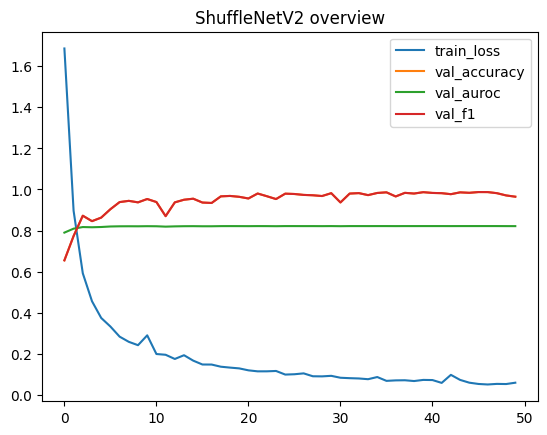

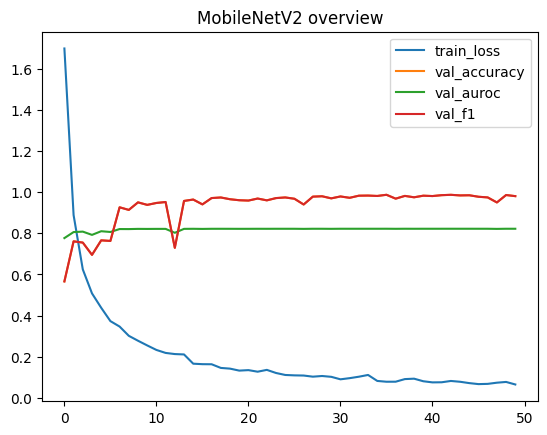

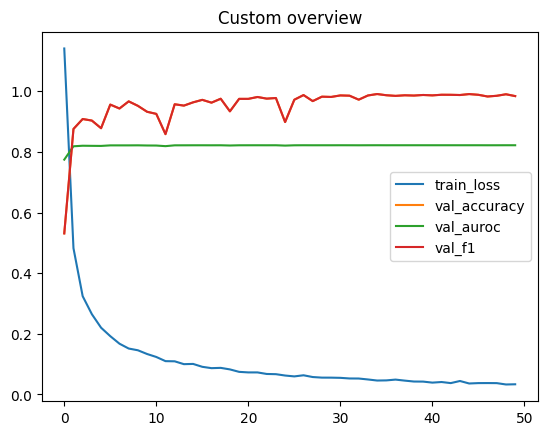

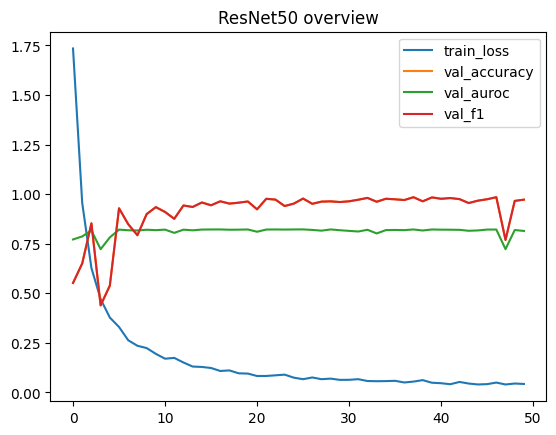

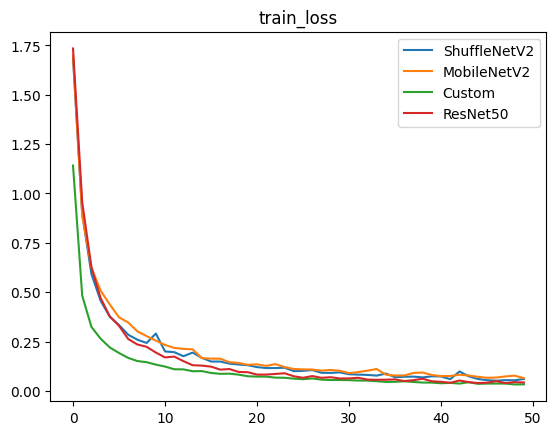

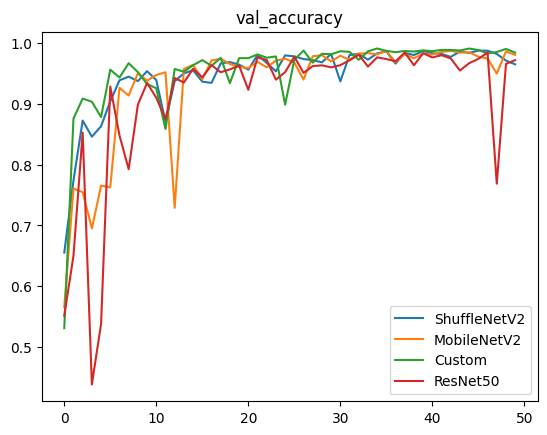

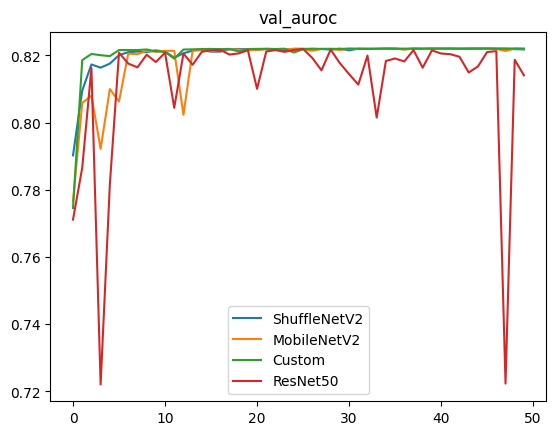

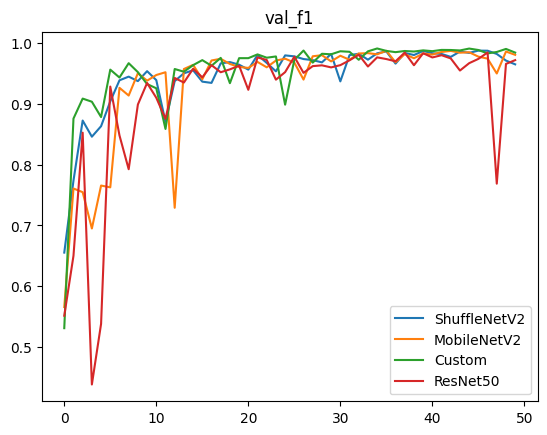

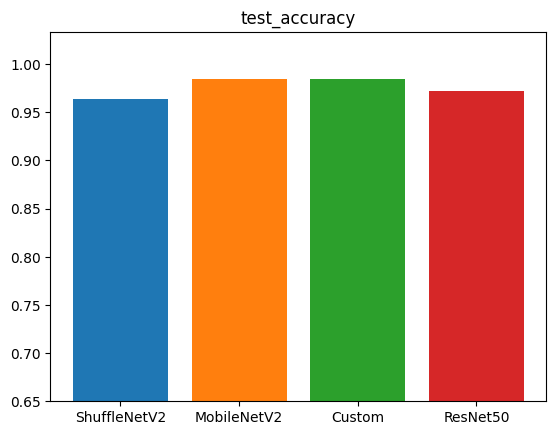

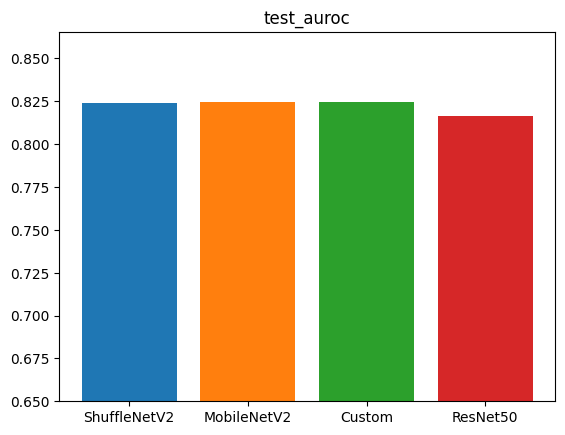

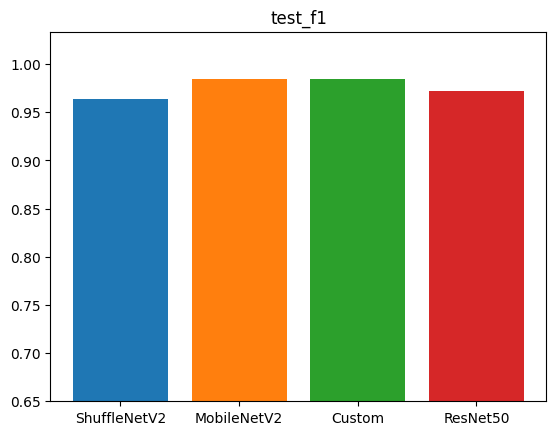

ShuffleNetV2 [{'test_accuracy': '0.9637275338172913', 'test_auroc': '0.8240759372711182', 'test_f1': '0.9637275338172913'}]
MobileNetV2 [{'test_accuracy': '0.9840754866600037', 'test_auroc': '0.8242745399475098', 'test_f1': '0.9840754866600037'}]
Custom [{'test_accuracy': '0.9843704104423523', 'test_auroc': '0.8243093490600586', 'test_f1': '0.9843704104423523'}]
ResNet50 [{'test_accuracy': '0.9721320867538452', 'test_auroc': '0.8162165284156799', 'test_f1': '0.9721320867538452'}]
ShuffleNetV2 1.4 M
MobileNetV2 3.5 M
Custom 363 K
ResNet50 25.6 M


In [61]:
from pathlib import Path

import polars as pl
import numpy as np
import torch
import torch.nn as nn
from torchvision.io import decode_image
from torchvision.transforms import v2
from torchvision.tv_tensors import Image, Mask
import lightning as L
from lightning.pytorch.utilities import model_summary
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.loggers import CSVLogger
import torchmetrics
import torchmetrics.segmentation
import segmentation_models_pytorch as smp

# Dev Imports
from icecream import ic

# usecase = "segmentation"
usecase = "classification"

model_path = Path("models") / usecase
log_path = Path("csv_logs") / usecase

models = [p.stem for p in log_path.iterdir()]
model_dfs = {}
for model in models:
  df = pl.read_csv(log_path / model / "version_0" / "metrics.csv")
  df = df.group_by(['epoch', 'step']).agg(pl.all().max()).sort('step')
  model_dfs[model] = df

model_df = list(model_dfs.values())[0]
metric_names = [col for col in model_df.columns if ("train" in col or "val" in col)]
test_metric_names = [col for col in model_df.columns if ("test" in col)]

import matplotlib.pyplot as plt

## Individual plots
# # TODO: Consolidate them into a single image
for model, model_df in model_dfs.items():
  epochs = model_df['epoch']
  metrics = model_df.select(metric_names)
  plt.plot(epochs, metrics, label=metric_names)
  plt.legend()
  plt.title(f"{model} overview")
  plt.show()

# ## Compare models
for metric_name in metric_names:
  for model, model_df in model_dfs.items():
    epochs = model_df['epoch']
    metric = model_df[metric_name]
    plt.plot(epochs, metric, label=model)
  plt.legend()
  plt.title(f"{metric_name}")
  plt.show()

for metric_name in test_metric_names:
  for model, model_df in model_dfs.items():
    epochs = model_df['epoch']
    if metric_name in model_df.columns:
      metric = float(model_df[metric_name].max())
      plt.bar([model], metric, label=model)
  plt.ylim(bottom=0.65)
  plt.title(f"{metric_name}")
  plt.show()

for model, model_df in model_dfs.items():
  try:
    print(model, model_df.select(test_metric_names).max().to_dicts())
  except:
    pass

for model in models:
  ep = torch.export.load(model_path / model / f"export_{model}.pt2")
  module = ep.module()
  print(model, model_summary.get_human_readable_count(model_summary.LayerSummary(module).num_parameters))

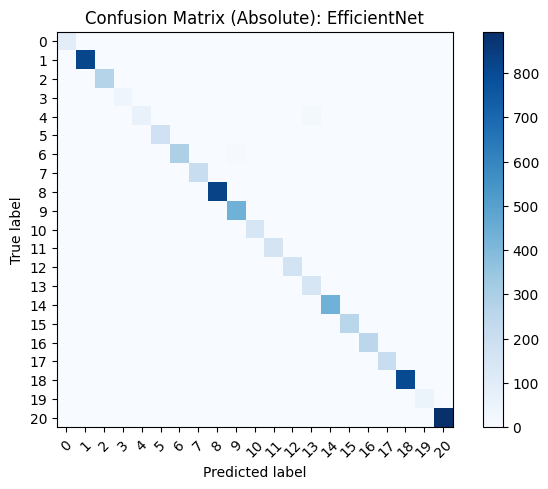

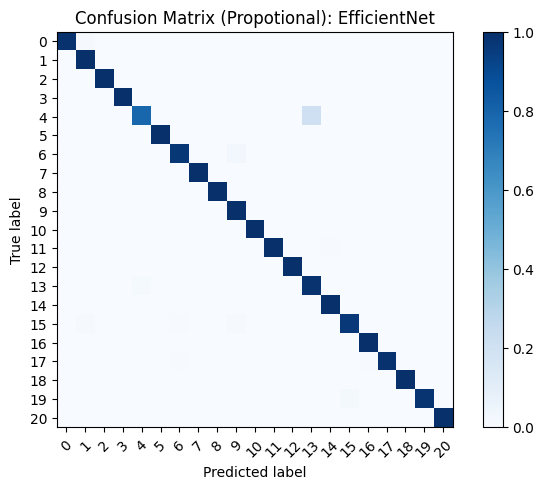

In [ ]:
class PlantVillageData(L.LightningDataModule):
  def __init__(self, ws_root: Path = Path("."), num_workers=0):
    super().__init__()
    metadata_path = ws_root / 'plantvillage_dataset' / 'metadata'
    self.train_ds = ImageDataset(pl.read_csv(metadata_path / 'resampled_training_set.csv').filter(pl.col('image_path').str.contains('augment').eq(False)), training=True)
    self.val_ds = ImageDataset(pl.read_csv(metadata_path / 'validation_set.csv'))
    self.test_ds = ImageDataset(pl.read_csv(metadata_path / 'test_set.csv'))

    self.n_classes = len(self.train_ds.disease_to_idx)
    self.idx_to_disease = {v:k for k,v in self.train_ds.disease_to_idx.items()}

    self.dataloader_extras = dict(
        num_workers = num_workers,
        pin_memory = True,
        persistent_workers = num_workers > 0
    )

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_ds, batch_size=32, shuffle=True, **self.dataloader_extras)

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_ds, batch_size=64, **self.dataloader_extras)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_ds, batch_size=64, **self.dataloader_extras)

class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe: pl.DataFrame, training=False):
    super().__init__()
    self.image_path = dataframe.select('image_path').to_numpy().squeeze().copy()
    self.disease_type = dataframe.select('disease_type').to_numpy().squeeze().copy()
    self.disease_to_idx = {disease: i for i, disease in enumerate(np.unique(self.disease_type))}

    self.training = training
    self.train_transforms = v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomErasing(),
    ])
    self.transforms = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
    ])

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, idx):
    image = decode_image(self.image_path[idx])
    if self.training:
      image = self.train_transforms(image)
    image = self.transforms(image)
    disease = self.disease_to_idx[self.disease_type[idx]]
    return image, disease

models = [p.stem for p in model_path.iterdir() if p.stem == "EfficientNet"]

plantvillage_data = PlantVillageData()
plantvillage_data.setup(None)
ds = plantvillage_data.test_ds
dl = plantvillage_data.test_dataloader()
cm_func = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=plantvillage_data.n_classes)
for model in models:
  # ep = torch.export.load(model_path / model / f"export_{model}.pt2")
  ep = torch.export.load(model_path / model / f"export_efficientnet_plantvillage.pt2")
  module = ep.module()
  module.cuda()
  cm = None
  with torch.inference_mode():
    for batch in dl:
      x, y = batch
      y_pred = module(x.cuda()).cpu()
      if cm is None:
        cm = cm_func(y_pred, y)
      else:
        cm = cm + cm_func(y_pred, y)
      # break
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Absolute): {model}')
    plt.colorbar()
    tick_marks = np.arange(plantvillage_data.n_classes)
    labels = range(plantvillage_data.n_classes)
    # labels = [plantvillage_data.idx_to_disease[i] for i in labels]
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    cm = cm / cm.sum(dim=1, keepdim=True)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Propotional): {model}')
    plt.colorbar()
    tick_marks = np.arange(plantvillage_data.n_classes)
    labels = range(plantvillage_data.n_classes)
    # labels = [plantvillage_data.idx_to_disease[i] for i in labels]
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
  # break


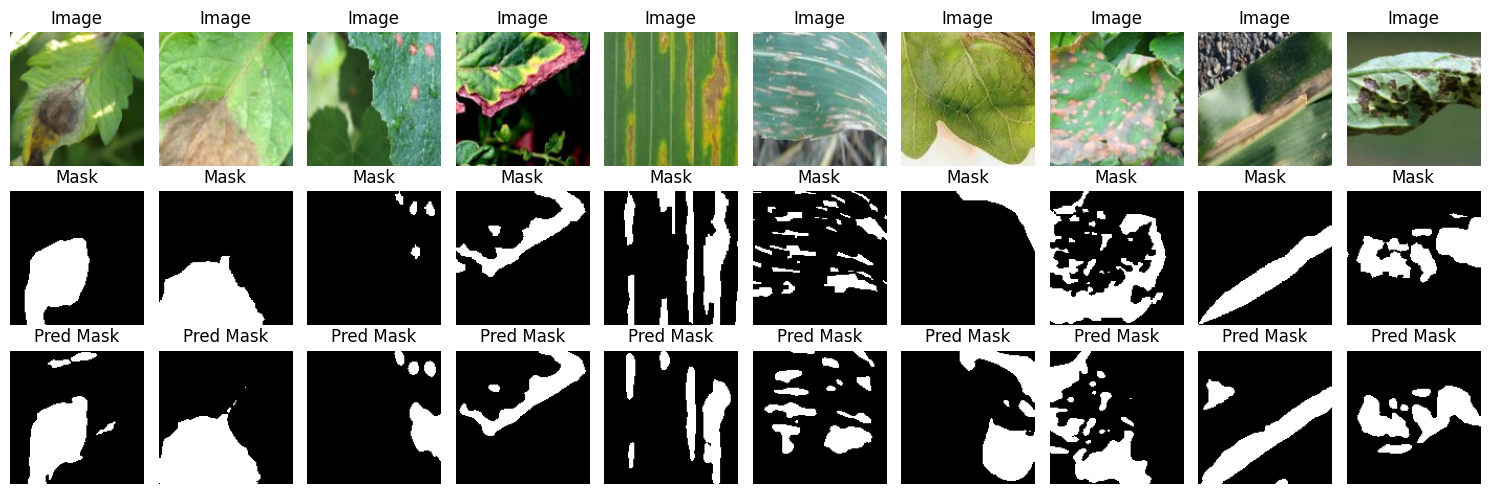

In [ ]:
import matplotlib.pyplot as plt

num_images_to_display = 10
fig, axes = plt.subplots(3, num_images_to_display, figsize=(15, 5))

plantvillage_data.setup(None)

for i in range(num_images_to_display):
    sample = plantvillage_data.test_ds[i]  # Get a sample from the dataset
    image, mask = sample  # Unpack the tuple
    with torch.no_grad():
      pred_mask = (lit_model.model(image.unsqueeze(0)) > 0)

    # Convert CHW (Channel-Height-Width) to HWC (Height-Width-Channel)
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
    mask = mask.squeeze().numpy()  # Squeeze single-channel mask tensor
    pred_mask = pred_mask.squeeze().numpy()

    # Plot the image
    axes[0, i].imshow(image)  # Display image
    axes[0, i].axis('off')
    axes[0, i].set_title('Image')

    # Plot the mask
    axes[1, i].imshow(mask, cmap='gray')  # Display mask
    axes[1, i].axis('off')
    axes[1, i].set_title('Mask')

    # Plot the pred mask
    axes[2, i].imshow(pred_mask, cmap='gray')  # Display pred mask
    axes[2, i].axis('off')
    axes[2, i].set_title('Pred Mask')

plt.tight_layout()
plt.show()